Shared Gene Dysregulation in Multiple SCA Models
========================
This notebook takes .csv notebooks containing lists of dysregulated genes and their gene expression changes (relative to WT), and seeks to determine what genes are dysregulated across multiple models of ataxia


Written by Ravi Chopra (chopra.r@wustl.edu) and John Cooper (jpcoope@utexas.edu)<br>
Last commit: 5/18/2020<br>
Python version: Python 3.6.3<br>
Modules: pandas 1.0.3, numpy 1.13.3, scipy 0.19.1, matplotlib 2.1.0, upsetplot 0.4.0 

In [1]:
#import statements
from itertools import combinations
import pandas as pd
import numpy as np
import scipy.stats as stats
import random
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from upsetplot import plot, from_memberships, from_contents
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

from diffex import utils, constants

### 1. Read in in data, set number of runs for overlap simulation, and set dfs and model_names lists

In [3]:
##Import gene expression data from ataxia mouse models to pandas dataframes
#Gene expression data sources are outlined the methods section. In all cases, raw data tables were modified so that .csv files
#below have 3 columns: 
#column 1 - dysregulated gene names
#column 2 - log2 transformation of the fold expression for gene in mouse model of interest relative to appropriate WT
#column 3 - fold expression for gene in mouse model of interest relative to appropriate WT

ATXN1_82Q_5_Wk = pd.read_csv('ATXN1_82Q_5_Week.csv')
ATXN1_154Q_5_12_Wk = pd.read_csv('ATXN1_154Q_5_12_Week.csv')
ATXN2_127Q_6_Wk = pd.read_csv('ATXN2_127Q_6_Week.csv')
ATXN2_72Q_8_Wk = pd.read_csv('ATXN2_72Q_8_Week.csv')

#Import a list of all ion channel genes found in mice
IUPHAR_Channels = constants.IUPHAR_Channels
IUPHAR_Channels_names = constants.IUPHAR_Channels_names

_n_runs = 1000

# Set up lists for making dictionary below
dfs = [ATXN1_82Q_5_Wk,
       ATXN1_154Q_5_12_Wk,
       ATXN2_127Q_6_Wk,
       ATXN2_72Q_8_Wk]

model_names = ['ATXN1_82Q_5_Wk',
               'ATXN1_154Q_5_12_Wk',
               'ATXN2_127Q_6_Wk',
               'ATXN2_72Q_8_Wk']

### 2. Clean the dataframes read in above and save them as .csvs. Put them into a dictionary called dfs_dict

In [3]:
# Clean the dfs
clean_dfs = []
for df in dfs:
    clean_dfs.append(utils.clean_dataframe(df))
    
# Save the cleaned dfs
i = 0
for df in clean_dfs:
    name = model_names[i]
    df.to_csv(f'{name}_cleaned.csv')
    i += 1
    
dfs_dict = dict(zip(model_names, clean_dfs))

No duplicated gene names in dataset for df with column 1: Log2(Fold expression) (ATXN1[82Q] vs. WT)


C:\diffex\lib\site-packages\pandas\core\frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### 3. Create a dataframe and dictionary to store dysregulated channels in each model and save the dataframe as 

In [4]:
dysreg_channels_df, channels_dict = utils.set_channels_df(dfs_dict, 'channels_dysreg_in_each_model.csv')
# this saves a .csv with each column a different model each row its dysregulated channels

### 4. Create a 'contents' data structure from the dictionary above and plot overlap distributions

Plot singlet overlaps and up. Note with the data in this form (constructed with from_contents()), the function is not plotting overlaps with 0 genes in overlap. 

(0.0, 50.0)

Text(0, 0.5, 'Genes in Overlap')

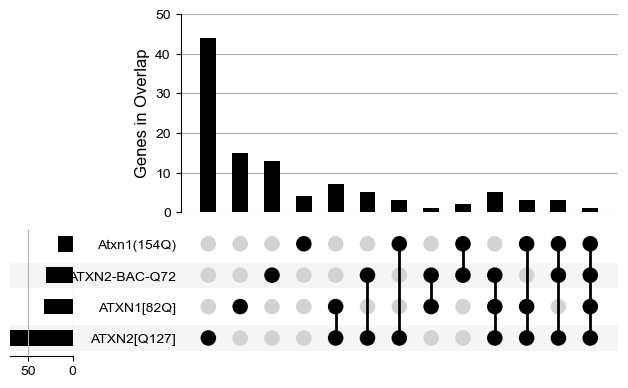

In [20]:
# Rename keys for aesthetic purposes
keys = ['ATXN1[82Q]',
        'Atxn1(154Q)',
        'ATXN2[Q127]',
        'ATXN2-BAC-Q72']

channels_dict = dict(zip(keys, channels_dict.values()))

contents = from_contents(channels_dict)

plot_dict = plot(contents)

plot_dict['intersections'].set_ylim(0, 50)
plot_dict['intersections'].set_ylabel('Genes in Overlap', fontsize=12)

plt.savefig('python_upset_with_singlet_overlaps.svg', dpi=300)

Plot pairwise overlaps and up

(0.0, 10.0)

Text(0, 0.5, 'Genes in Overlap')

(3.5, 12.875)

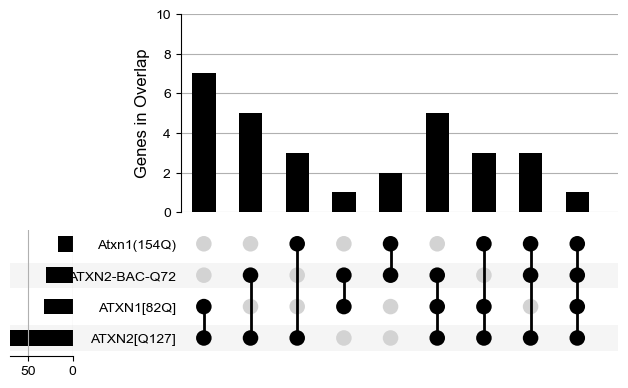

In [6]:
plot_dict = plot(contents)

#plot_dict['totals'].set_xlim(50, 0)

plot_dict['intersections'].set_ylim(0, 10)
plot_dict['intersections'].set_ylabel('Genes in Overlap', fontsize=12)
plot_dict['intersections'].set_xlim(3.5, 12.875)

plt.savefig('python_upset_pairwise_and_up.svg', dpi=300)

### 5. Find pairwise overlaps and analyze overlap significance with hypergeometric test

In [7]:
pairwise_overlaps_df = utils.find_pairwise_overlaps(dfs_dict)
pairwise_overlaps_df.to_csv('pairwise_all_genes_overlaps.csv')
pairwise_channels_overlaps = utils.drop_non_channels(pairwise_overlaps_df,
                                              'pairwise_channels_overlaps.csv')
pairwise_overlaps_list = [pairwise_overlaps_df.loc[:, column].dropna() for column in pairwise_overlaps_df.columns]
pairwise_overlaps_names = pd.concat(pairwise_overlaps_list).unique()

pairwise_overlaps_channels = pd.Series(list(set(pairwise_overlaps_names).intersection(set(IUPHAR_Channels_names))))

In [8]:
utils.hypergeometric_test(dfs_dict)

ATXN1_82Q_5_Wk and ATXN1_154Q_5_12_Wk p-value=0.028727814921322814
ATXN1_82Q_5_Wk and ATXN2_127Q_6_Wk p-value=0.0005124345063888258
ATXN1_82Q_5_Wk and ATXN2_72Q_8_Wk p-value=0.014406874471300068
ATXN1_154Q_5_12_Wk and ATXN2_127Q_6_Wk p-value=0.0002980442903435243
ATXN1_154Q_5_12_Wk and ATXN2_72Q_8_Wk p-value=0.0005893463610623373
ATXN2_127Q_6_Wk and ATXN2_72Q_8_Wk p-value=0.0027472618229910095


### 6. Find all channels that are dysregulated in 3 or more models and simulate random channel selections to see if similar overlaps to those observed occur by chance

In [9]:
# Find the set of all genes that are shared in 3 or more models
triplet_overlaps_df = utils.find_triplet_overlaps(dfs_dict)
triplet_overlaps_df.to_csv('triplet_all_genes_overlaps_df.csv')
triplet_channels_overlaps = utils.drop_non_channels(triplet_overlaps_df,
                                              'triplet_channels_overlaps.csv')
triplet_overlaps_list = [triplet_overlaps_df.loc[:, column].dropna() for column in triplet_overlaps_df.columns]
triplet_overlaps_names = pd.concat(triplet_overlaps_list).unique() # returns a series object

# Find the set of all channel genes that are shared in 3 or more models
triplet_overlaps_channels = pd.Series(list(set(triplet_overlaps_names).intersection(set(IUPHAR_Channels_names))))
triplet_overlaps_channels_num = len(triplet_overlaps_channels)
print('Total number of channels dysregulated in any 3 models =', triplet_overlaps_channels_num)

Total number of channels dysregulated in any 3 models = 12


In [10]:
n_channels_dict = utils.get_n_channels_dict(dfs_dict)
overlaps, count = utils.simulate_triplet_overlaps(dfs_dict,
                                            n_runs=_n_runs,
                                            observed_overlap_n=triplet_overlaps_channels_num,
                                            n_channels_dict=n_channels_dict)

print('Count of number of runs out of', _n_runs, 'greater than/equal to', triplet_overlaps_channels_num, 'channel genes in overlap of any 3 models:', count)
Three_sim_pvalue = count/_n_runs
print('p-value for greater than/equal to 20 channel genes in all intersections of 3 models:', Three_sim_pvalue)

Count of number of runs out of 1000 greater than/equal to 12 channel genes in overlap of any 3 models: 0
p-value for greater than/equal to 20 channel genes in all intersections of 3 models: 0.0


### 7. Find all channels that are dysregulated in all 4 models and simulate random channels selections to see if similar overlap to that observed occurs by chance

In [11]:
# Find the set of all genes that are shared in all 4 models
quad_overlaps_df = utils.find_quad_overlaps(dfs_dict)
quad_overlaps_df.to_csv('quad_all_genes_overlaps_df.csv')
quad_channels_overlaps = utils.drop_non_channels(quad_overlaps_df,
                                           'quad_channels_overlaps.csv')
quad_overlaps_list = [quad_overlaps_df.loc[:, column].dropna() for column in quad_overlaps_df.columns]
quad_overlaps_names = pd.concat(quad_overlaps_list).unique() # returns a series object

# Find the set of all channel genes that are shared in 3 or more models
quad_overlaps_channels = pd.Series(list(set(quad_overlaps_names).intersection(set(IUPHAR_Channels_names))))
quad_overlaps_channels_num = len(quad_overlaps_channels)
print('Total number of channels dysregulated in all 4 models =', quad_overlaps_channels_num)

Total number of channels dysregulated in all 4 models = 1


In [12]:
n_channels_dict = utils.get_n_channels_dict(dfs_dict)
overlaps, count = utils.simulate_quad_overlaps(dfs_dict,
                                         n_runs=_n_runs,
                                         observed_overlap_n=quad_overlaps_channels_num,
                                         n_channels_dict=n_channels_dict)

print('Count of number of runs out of', _n_runs, 'greater than/equal to', quad_overlaps_channels_num, 'channel genes in overlap of all 4 models:', count)
Three_sim_pvalue = count/_n_runs
print('p-value for greater than/equal to 20 channel genes in all intersections of 3 models:', Three_sim_pvalue)

Count of number of runs out of 1000 greater than/equal to 1 channel genes in overlap of all 4 models: 50
p-value for greater than/equal to 20 channel genes in all intersections of 3 models: 0.05


### 8. Plot all unique intersections between models for final figure. 
This requires some restructuring of the data produced above

In [13]:
# Populate groups with every combination of models from size none to 4
# Each group is a list of model names in that combination.
groups = [[]]
for k_size in range(1, 5):
    
    for combination in utils.get_combinations(model_names, k_size):
        groups.append(list(combination))

# Define dysreg_channels_df, channels_dict without saving
dysreg_channels_df, channels_dict = utils.set_channels_df(dfs_dict, False)

In [14]:
# Create a dataframe where each column is one of every combination
# of model names size none to 4 referring to the list of channels
# dysregulated in the intersection of that combination
master_overlaps_df = pd.concat([dysreg_channels_df,
                                pairwise_channels_overlaps,
                                triplet_channels_overlaps,
                                quad_channels_overlaps], ignore_index=False, sort=False)
# Other sets that are used in contrasts below. We need a list of all channels in the
# IUPHAR channels database and a list of all the channels dysregulataed in any of the
# models to create the none set
all_channels_list = [master_overlaps_df.loc[:, column].dropna() for column in master_overlaps_df.columns]
all_channels_names = pd.concat(all_channels_list).unique()
IUPHAR_Channels_set = set(IUPHAR_Channels_names)
none_set = IUPHAR_Channels_set.difference(all_channels_names)

In [15]:
# Create a list of the number of channels dysregulated uniquely in the
# intersection of each combination of models from size none to 4.
n_unique_channels_list = [len(none_set)]
for i in range(1, len(groups)):    
    
    group = groups[i]    
    if len(group) == 1:
        key = group[0]
        channels = master_overlaps_df[key].dropna()     
        unique_names = set(channels).difference(set(pairwise_overlaps_names))
        n_unique_channels_list.append(len(unique_names))

    elif len(group) == 2:
        key = '-'.join(group)
        channels = master_overlaps_df[key].dropna()
        unique_names = set(channels).difference(set(triplet_overlaps_names))
        n_unique_channels_list.append(len(unique_names))
        
    elif len(group) == 3:
        key = '-'.join(group)
        channels = master_overlaps_df[key].dropna()
        unique_names = set(channels).difference(set(quad_overlaps_names))
        n_unique_channels_list.append(len(unique_names))
        
    elif len(group) == 4:
        key = '-'.join(group)
        channels = master_overlaps_df[key].dropna()
        unique_names = channels
        n_unique_channels_list.append(len(unique_names))        
    else:
        print("Too many groups in list")

In [16]:
n_unique_channels_list

[164, 15, 4, 44, 13, 0, 7, 1, 3, 2, 5, 3, 0, 5, 3, 1]

In [17]:
# Rename keys for aesthetic purposes
keys = ['ATXN1[82Q]',
        'Atxn1(154Q)',
        'ATXN2[Q127]',
        'ATXN2-BAC-Q72']
# Get every combination of models from size none to 4
# from keys defined above. Used to label intersections
# on x axis in plot below
plot_groups = [[]]
for k_size in range(1, 5):    
    for combination in utils.get_combinations(keys, k_size):
        plot_groups.append(list(combination))

(0.0, 50.0)

Text(0, 0.5, 'IUPHAR Ion Channel Genes (Count)')

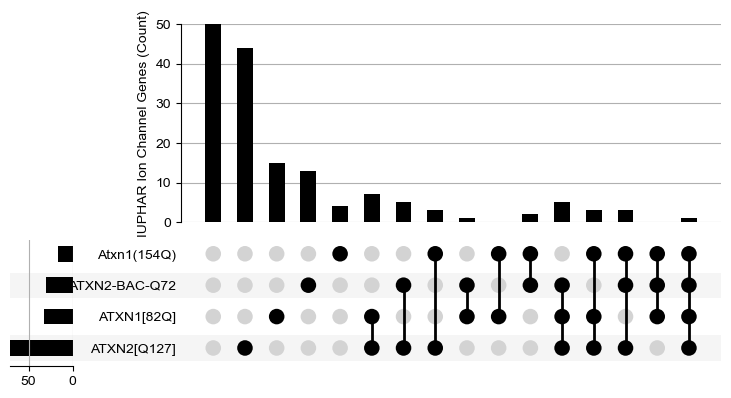

In [18]:
plot_list = from_memberships(plot_groups[:], data=n_unique_channels_list[:])
plot_dict = plot(plot_list)

x_lim = ()
y_lim = (0, 50)

plot_dict['intersections'].set_ylim(y_lim[0], y_lim[1])
plot_dict['intersections'].set_ylabel('IUPHAR Ion Channel Genes (Count)', fontsize=10)

plt.savefig(f'Upset_all_groups_ylim({y_lim[0]},{y_lim[1]}).svg', dpi=300)

(150.0, 200.0)

Text(0, 0.5, 'IUPHAR Ion Channel Genes (Count)')

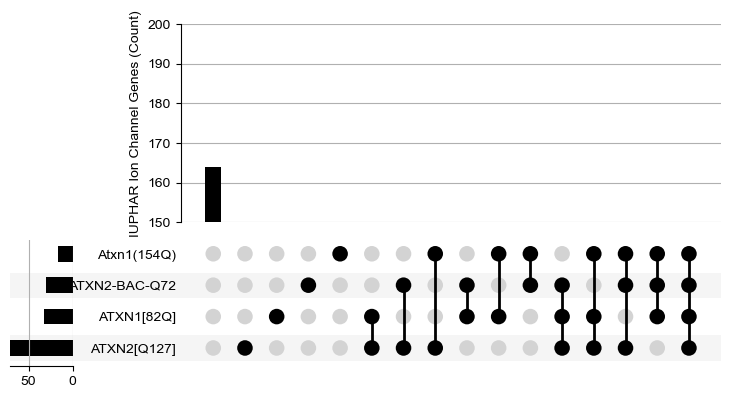

In [19]:
plot_list = from_memberships(plot_groups[:], data=n_unique_channels_list[:])
plot_dict = plot(plot_list)

x_lim = ()
y_lim = (150, 200)

plot_dict['intersections'].set_ylim(y_lim[0], y_lim[1])
plot_dict['intersections'].set_ylabel('IUPHAR Ion Channel Genes (Count)', fontsize=10)

plt.savefig(f'Upset_all_groups_ylim({y_lim[0]},{y_lim[1]}).svg', dpi=300)

### Channel genes dysregulated in Orr and/or Lim datasets

In [17]:
import pandas as pd
from diffex import constants
# Where to save the output file
output_filename = "ATXN1_154Q_12_Week_Lim_Orr_channels_merge.csv"

Lim_df = pd.read_csv('ATXN1_154Q_12_Week_Lim.csv')
Orr_df = pd.read_csv('ATXN1_154Q_18_Week_Orr.csv')

merged_df = pd.merge(left=Lim_df,
              right=Orr_df,
              how='outer',
              on='Gene name',
              suffixes=("_Lim", "_Orr"))
# Select only channel genes from the original datasets
# to output to csv
channels_merged_df = merged_df[merged_df['Gene name'].isin(constants.IUPHAR_Channels_names)].reset_index()
channels_merged_df.to_csv(output_filename, index=False)

channels_merged_df.head()

,index,Gene name,Log2(Fold expression) (Atxn1-154Q vs. WT)_Lim,Fold Expression (Atxn1-154Q vs. WT)_Lim,Log2(Fold expression) (Atxn1-154Q vs. WT)_Orr,Fold Expression (Atxn1-154Q vs. WT)_Orr
0,2,Kcnb2,0.747733,1.679160,0.741469,1.671878
1,22,Kcnt2,-1.218370,0.429768,NaN,NaN
2,32,Kcnj10,-0.298845,0.812904,NaN,NaN
3,34,Kcnh1,0.304301,1.234820,NaN,NaN
4,39,Kcnq5,-1.246740,0.421401,NaN,NaN


### Classifying the effects of 82Q-point mutant (PM) on the expression of channel genes dysregulated in 82Q mouse

In [23]:
import itertools
import re
import pandas as pd

# Use significance threshold of .01 for all 
# calculations
alpha = 0.01
df = pd.read_excel('ATXN1-82Q_vs_ATXN1-82Q-Cic-Mut_Channelome.xlsx')
# Select the columns that will be used for analysis from the 
# original dataframe
cols = ['gene',
        '82QvsWT_log2FoldChange',
        '82QvsWT_padj',
        '591vsWT_log2FoldChange',
        '591vsWT_padj', 
        '591vs82Q_log2FoldChange', 
        '591vs82Q_padj']
df = df.loc[:, cols]
# Get rid of rows that have missing values
df = df.dropna(axis=0, how='any')
# We're only interested in genes significantly dysregulated in
# the 82Q mouse, so filter out all others ehre
df = df.loc[df.loc[:, '82QvsWT_padj'] < alpha, :]
df.reset_index(inplace=True, drop=True)
df.head()

,gene,82QvsWT_log2FoldChange,82QvsWT_padj,591vsWT_log2FoldChange,591vsWT_padj,591vs82Q_log2FoldChange,591vs82Q_padj
0,Aqp4,0.578279,7.440038e-25,0.107899,0.380881,-0.470379,3.814505e-16
1,Aqp6,-0.419049,7.348852e-08,-0.070399,0.758449,0.348651,1.680618e-05
2,Asic2,0.196005,1.174781e-03,-0.019705,0.932387,-0.215709,3.742454e-04
3,Cacna1a,-0.301159,1.919880e-07,-0.047865,0.787508,0.253294,2.466478e-05
4,Cacna1b,-0.167375,5.359174e-03,0.023317,0.914175,0.190692,1.473405e-03


After filtering out channel genes with `82QvsWT_padj` > 0.01, the effects of Cic PM are defined by the four following groups:

1. Total rescue
    * log2(82Q-PM/wt) does not significantly differ from 0
    * log2(82Q-PM/82Q) does significantly differ from 0
2. Partial rescue
    * Negative case
        * log2(82Q/wt) < 0
        * log2(82Q-PM/wt) < 0
        * log2(82Q-PM/82Q) > 0
    * Positive case
        * log2(82Q/wt) > 0
        * log2(82Q-PM/wt) > 0
        * log2(82Q-PM/82Q) < 0
3. No rescue
    * log2(82Q-PM/82Q) does not significantly differ from 0
4. Excacerbation
    * Negative case
        * log2(82Q/wt) < 0
        * log2(82Q-PM/wt) < 0
        * log2(82Q-PM/82Q) < 0
    * Positive case
        * log2(82Q/wt) > 0
        * log2(82Q-PM/wt) > 0
        * log2(82Q-PM/82Q) > 0

In [24]:
def evaluate_effect_on_gene(df, gene, alpha):
    
    df = df.set_index('gene')

    pattern = []
    pattern.append(df.loc[gene, '82QvsWT_log2FoldChange'] < 0)
    pattern.append(df.loc[gene, '591vsWT_log2FoldChange'] < 0)
    pattern.append(df.loc[gene, '591vsWT_padj'] < alpha)
    pattern.append(df.loc[gene, '591vs82Q_log2FoldChange'] < 0)
    pattern.append(df.loc[gene, '591vs82Q_padj'] < alpha)
    # Convert the pattern into a string so that it's
    # easier to evaluate with regex
    pattern = '-'.join([str(boolean) for boolean in pattern])
    return pattern

# Total rescue: Gene is significantly up or down in 82Q, NOT significantly
# up or down in 82Q-PM, and log2 fold changes from wild-type significantly
# differ between 82Q-PM and 82Q
total_rescue_pattern = r'(True|False)-(True|False)-(False)-(True|False)-(True)'
# No rescue: Gene is significantly up or down in 82Q, significantly up or down
# in 82Q-PM, and log2 fold changes from wild-type do NOT significantly differ 
# between 82Q-PM and 82Q
no_rescue_pattern = r'(True|False)-(True|False)-(True)-(True|False)-(False)'
# Partial rescue: Gene is either (1) significantly down in 82Q, significantly down in
# 82Q-PM, and the log2 fold change from wild-type is significantly less negative
# in 82Q-PM than in 82Q or (2) gene is significantly up in 82Q, significantly up
# in 82Q-PM, and the log2 fold change from wild-type is significantly more positive
# in 82Q-PM than in 82Q
partial_rescue_pattern = r'(True-True-True-False-True|False-False-True-True-True)'
# Exacerbation: Gene is either (1) down in 82Q, significantly down in
# 82Q-PM, and the log2 fold change from wild-type is significantly more negative
# for 82Q-PM than 82Q or (2) gene is up in 82Q, significantly up in 82Q-PM, and
# the log2 fold change from wild-type is significantly more positive in 82Q-PM
# than in 82Q
exacerbation_pattern = f'(True-True-True-True-True|False-False-True-False-True)'
# Evaluate pattern for each gene and store
# it in outcome_dict
outcome_dict = {}
for gene in df.gene.values:
    outcome = evaluate_effect_on_gene(df, gene, alpha)
    outcome_dict[gene] = outcome

In [25]:
patterns_dict = {'total_rescue': total_rescue_pattern,
                 'no_rescue': no_rescue_pattern,
                 'partial_rescue': partial_rescue_pattern,
                 'exacerbation': exacerbation_pattern}

matches_dict = {'total_rescue': [],
                 'no_rescue': [],
                 'partial_rescue': [],
                 'exacerbation': []}
# For each type of 82Q-PM effect pattern defined
# above, make a list of gene names that conform
# and add that list to matches_dict
for pattern_name, pattern in patterns_dict.items():
    for gene, gene_outcome, in outcome_dict.items():
        m = re.search(pattern, gene_outcome)
        if m:
            matches_dict[pattern_name].append(gene)
    # Let the user know how many genes were found
    # for each group
    print(f'{pattern_name}: {len(matches_dict[pattern_name])} genes')
    # Save the csv for that 82Q-PM effect type
    filename = f'82Q-PM_{pattern_name}.csv'
    df.set_index('gene').loc[matches_dict[pattern_name], :].reset_index().to_csv(filename, index=False)

total_rescue: 54 genes
no_rescue: 1 genes
partial_rescue: 4 genes
exacerbation: 0 genes
